In [1]:
from collections import Counter
import os

from graphviz import Source
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import networkx as nx
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns


sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

In [2]:
def new_count_row(all_clone_names, clone_name=None):
    """ Create a DataFrame row with one entry per clone name. 
    
    If `clone_name` is not None, initialize that entry to 1.
    """
    row = pd.Series(data=0, index=all_clone_names)
    if clone_name is not None:
        row[clone_name] = 1
    return row

def dfs_clones_count(g, clones, all_clone_names, source_node):
    clones_count = pd.DataFrame({sample_name: new_count_row(all_clones, clone_name) for sample_name, clone_name in clones.items()})
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(g, source_node):
        if edge_label is not 'reverse' or pre_node == post_node: 
            continue
        pre_node_counter = clones_count.get(pre_node, new_count_row(all_clones))
        if post_node not in clones_count.columns:
            print('!! possible mutation in a leaf: not found', post_node)
            continue
        clones_count[pre_node] = pre_node_counter + clones_count[post_node]

    return clones_count

def purity(clones_count):
    return clones_count.div(clones_count.sum(axis=0), axis=1)

def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node

# Load clones data

In [3]:
clones_data = pd.read_csv('../../data/YFV2001_clone_key/sample_order_clone_key_mem_scores_scRNAseq_sub1.csv')

In [4]:
clones_data.head()

,clone,tree_id,cell_id,mem_score,timepoint
0,bulk,s0,P3861_210.txt,NaN,NaN
1,107.0,s10,P1299_1141,0.043586,15.0
2,107.0,s54,P1299_1514,NaN,136.0
3,107.0,s55,P1299_1529,NaN,136.0
4,107.0,s56,P1299_1535,NaN,136.0


In [5]:
clones_map = dict(clones_data[['tree_id', 'clone']].values)
all_clones = list(clones_data.clone.unique())

In [6]:
print(all_clones)

['bulk', '107.0', '108.0', '118.0', '122.0', '143.0', '149.0']


# Load tree

In [8]:

#tree_filename = f'../../../mt-SCITE/mt-SCITE_output/YFV2001/{error_rate}/{error_rate}_map{tree_number}.gv'
tree_filename = f'../../../mt-SCITE/mt-SCITE_output/YFV2001/0.06_1_map0.gv'

tree = nx.drawing.nx_pydot.read_dot(tree_filename)

In [11]:
# tree contains some empty trailing node. Check that it is removed.
print(len(tree.nodes()))
#tree.remove_node('\\n')
print(len(tree.nodes()))

110
110


# Color by clone purity

['107.0', '108.0', '118.0', '122.0', '143.0', '149.0']


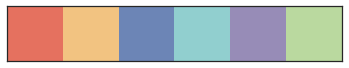

In [12]:
flatui = ['#E5715F', '#F2C381', '#6C85B6', '#91CFCF', '#978CB7', '#BAD99F'] 
sns.palplot(sns.color_palette(flatui))
print(all_clones[1:])

In [13]:
all_clones

['bulk', '107.0', '108.0', '118.0', '122.0', '143.0', '149.0']

In [14]:
flatui = ['#E5715F', '#F2C381', '#6C85B6', '#91CFCF', '#978CB7', '#BAD99F'] 
colors = sns.color_palette(sns.color_palette(flatui))

clone_color = {
    all_clones[i + 1]: np.array(colors[i]) * 255 for i in range(len(all_clones) - 1)
}
clone_color['bulk'] = (0, 0, 0)

In [15]:
def rgb_to_hex(colortuple):
    return '#' + ''.join(f'{int(i):02X}' for i in colortuple)

def mix_clones_colors(node_name, purities):
    node_purities = purities[node_name]
    color = 0
    for clone, frac in node_purities.iteritems():
        color += frac * np.array(clone_color[clone])
    return color.astype(int)


clones_count = dfs_clones_count(tree, clones_map, all_clones, source_node=get_root_node(tree))
clones_purity = purity(clones_count)

for n in tree.nodes:
    node_dict = tree.nodes[n]
    if n.startswith('s'):
        # This is the style for sample nodes
        clone = clones_map[n]
        node_dict['color'] = rgb_to_hex(clone_color[clone])
        node_dict['fontcolor'] = rgb_to_hex(clone_color[clone])
        node_dict['shape'] = 'circle'
    else:
        if n in clones_purity:
            # This is the style for mutation nodes
            # Color is a mix of purities
            #node_dict['color'] = rgb_to_hex(mix_clones_colors(n, clones_purity))
            node_dict['color'] = rgb_to_hex(mix_clones_colors(n, clones_purity))
            node_dict['fontcolor'] = rgb_to_hex(mix_clones_colors(n, clones_purity))
        else:
            # Dangling mutation node
            node_dict['color'] = 'black'

In [16]:
# Global graph style
tree.graph['node']['shape'] = 'square'
tree.graph['node']['fontcolor'] = 'white'
tree.graph['edges'] = {'arrowsize': '4.0'}
tree.graph


{'name': 'G',
 'node': {'color': 'deeppink4',
  'style': 'filled',
  'fontcolor': 'white',
  'shape': 'square'},
 'edges': {'arrowsize': '4.0'}}

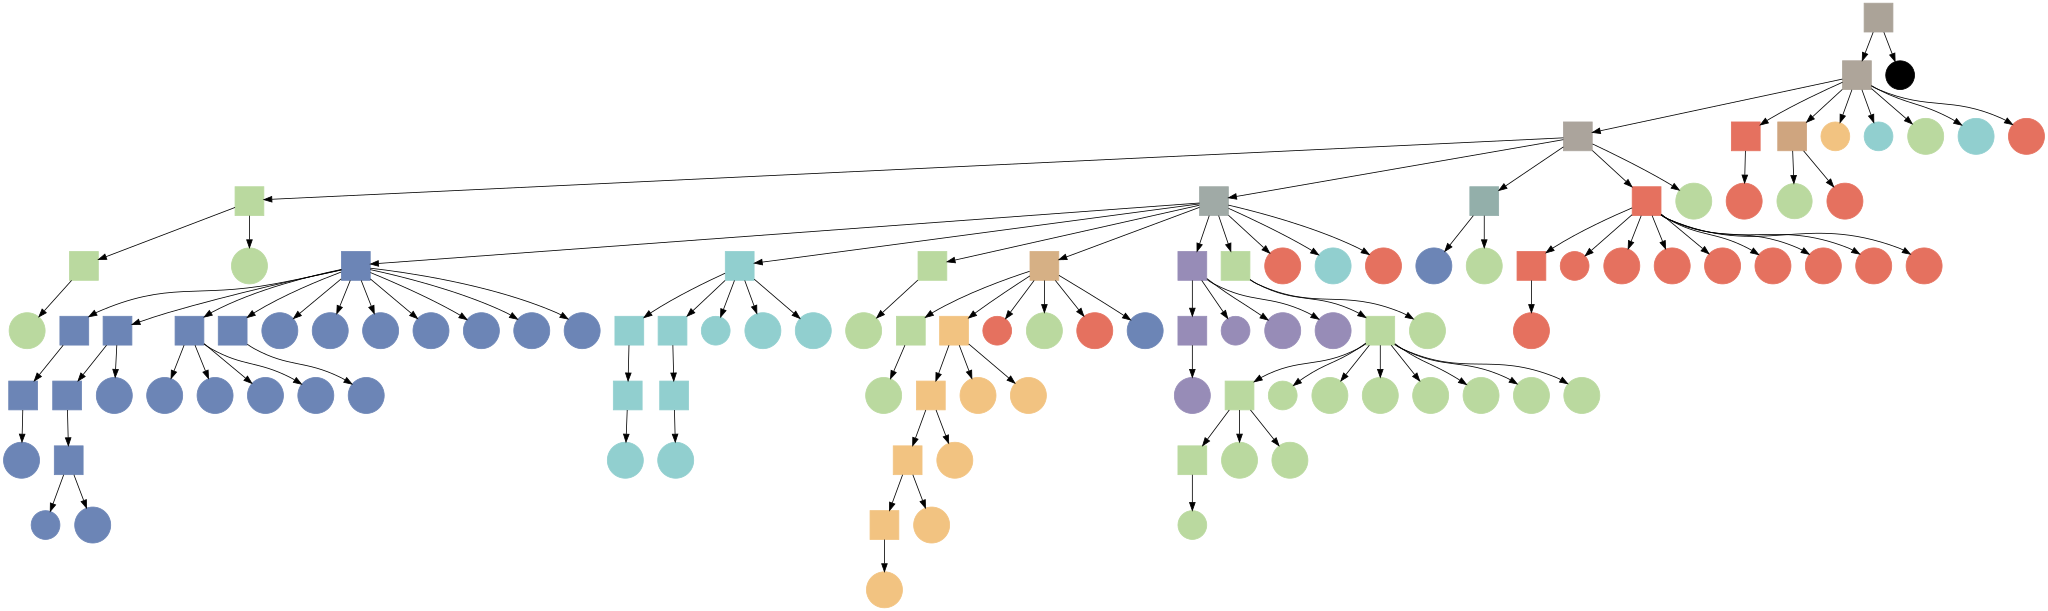

In [17]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
g = to_agraph(tree)
g.layout('dot')
g.draw(f'../../data/YFV2001_figures/0.06_1_map0.svg')
Source(g)

# Color by effector score

In [18]:
tree = nx.drawing.nx_pydot.read_dot(tree_filename)

In [20]:
# tree contains some empty trailing node. Check that it is removed.
print(len(tree.nodes()))
#tree.remove_node('\\n')
print(len(tree.nodes()))

110
110


In [21]:
cell_id_to_mem_score = dict(zip(clones_data['tree_id'], clones_data['mem_score']))
cell_id_to_time = dict(zip(clones_data['tree_id'], clones_data['timepoint']))

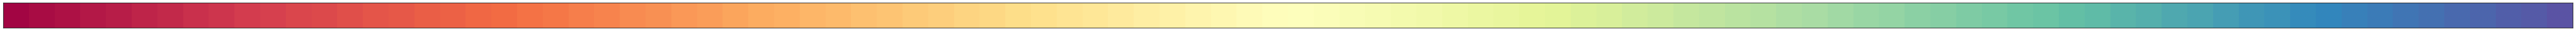

In [22]:
mem_score_colors = sns.color_palette("Spectral_r", 100)[::-1]
sns.palplot(mem_score_colors)
#plt.savefig('../../data/YFV2001_figures/mem_color_key.svg', dpi=300, bbox_inches='tight', transparent=True)

In [23]:
mem_score_colors = np.array(mem_score_colors) * 255

In [24]:
def rgb_to_hex(colortuple):
    return '#' + ''.join(f'{int(i):02X}' for i in colortuple)


clones_count = dfs_clones_count(tree, clones_map, all_clones, source_node=get_root_node(tree))
clones_purity = purity(clones_count)

for n in tree.nodes:
    node_dict = tree.nodes[n]
    if n.startswith('s'):
        # This is the style for sample nodes
        node_dict['shape'] = 'circle'
        if n not in cell_id_to_mem_score:
            node_dict['fillcolor'] = 'black'
            node_dict['fontcolor'] = 'white'
        else:
            score = cell_id_to_mem_score[n]
            if np.isnan(score):
                node_dict['fillcolor'] = 'white'
                node_dict['color'] = 'black'
            else:
                #print(n, score, mem_score_colors[int(score*100)])
                node_dict['fillcolor'] = rgb_to_hex(mem_score_colors[int(score*100)])
    else:
        if n in clones_purity:
            # This is the style for mutation nodes
            # Color is a mix of purities
            node_dict['fillcolor'] = rgb_to_hex(mix_clones_colors(n, clones_purity))
        else:
            # Dangling mutation node
            node_dict['fillcolor'] = 'black'

In [25]:
# Global graph style
tree.graph['node']['shape'] = 'square'
tree.graph['node']['fontcolor'] = 'black'
tree.graph['node']['color'] = 'black'
tree.graph['node']['style'] = 'filled,solid'
tree.graph['edges'] = {'arrowsize': '4.0'}
tree.graph

{'name': 'G',
 'node': {'color': 'black',
  'style': 'filled,solid',
  'fontcolor': 'black',
  'shape': 'square'},
 'edges': {'arrowsize': '4.0'}}

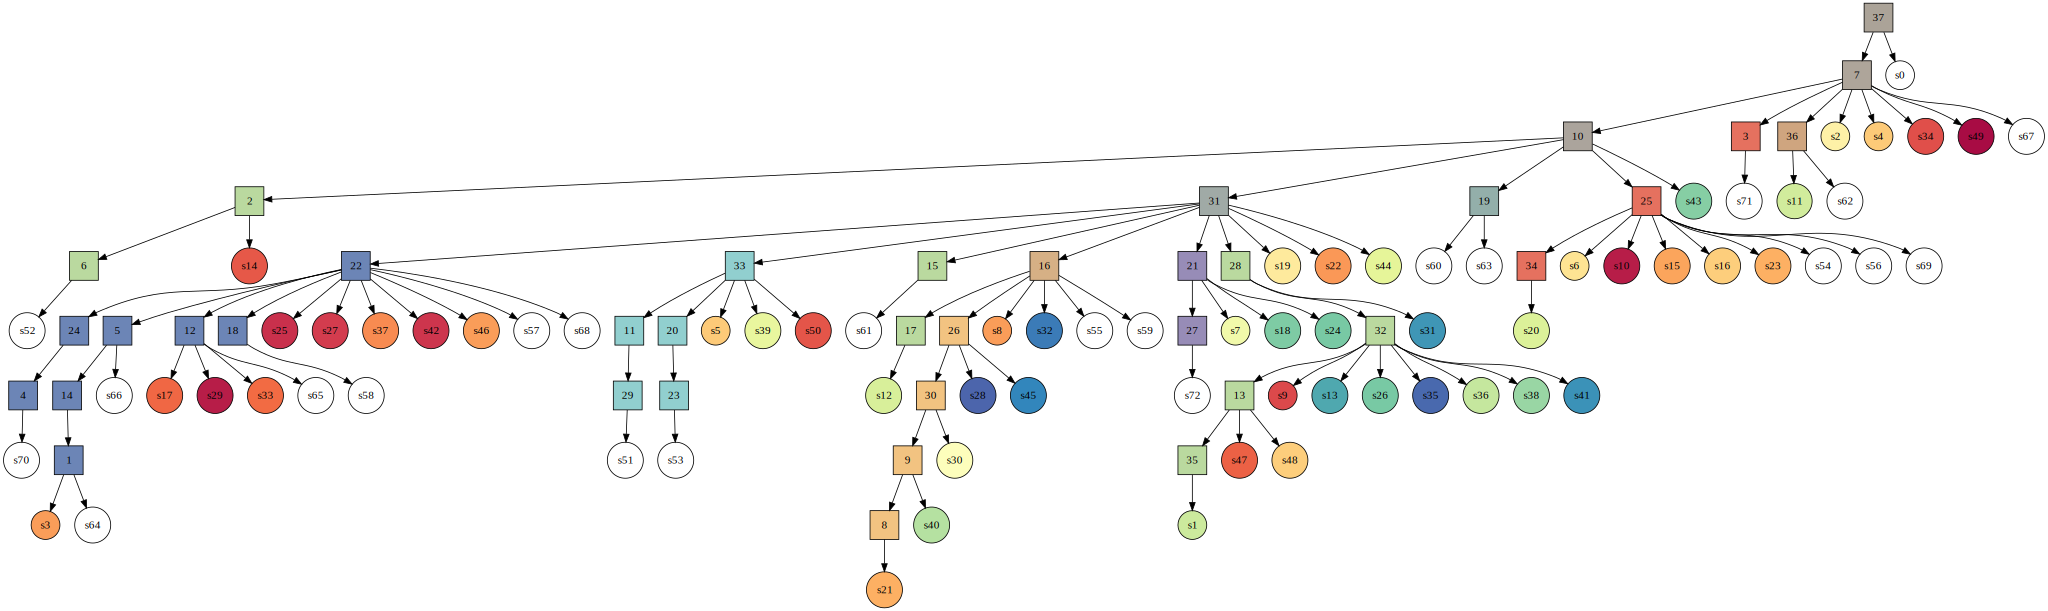

In [34]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
#g = to_agraph(tree)
#g.layout('dot')
#Source(g)

g = to_agraph(tree)
g.layout(prog='dot')
#g.draw(f'data/figs/mem_trees/YFV2001_sub1/Y_mem_scores_full_tree.pdf')
Source(g)

# Plot mem score and timepoint

In [35]:
def mem_style_tree(tree):
    for n in tree.nodes:
        node_dict = tree.nodes[n]
        if n.startswith('s'):
            # This is the style for sample nodes
            node_dict['shape'] = 'circle'
            if n not in cell_id_to_mem_score:
                node_dict['fillcolor'] = 'black'
                node_dict['fontcolor'] = 'white'
            else:
                score = cell_id_to_mem_score[n]
                if np.isnan(score):
                    node_dict['fillcolor'] = 'white'
                    node_dict['color'] = 'black'
                else:
                    #print(n, score, mem_score_colors[int(score*100)])
                    node_dict['fillcolor'] = rgb_to_hex(mem_score_colors[int(score*100)])
        else:
            if n in clones_purity:
                # This is the style for mutation nodes
                # Color is a mix of purities
                #node_dict['fillcolor'] = rgb_to_hex(mix_clones_colors(n, clones_purity))
                node_dict['fontcolor'] = '#EEF0F0'
            else:
                # Dangling mutation node
                node_dict['fillcolor'] = 'black'

    tree.graph['node']['shape'] = 'square'
    tree.graph['node']['fontcolor'] = 'black'
    tree.graph['node']['color'] = 'black'
    tree.graph['node']['style'] = 'filled,solid'
    tree.graph['edges'] = {'arrowsize': '4.0'}

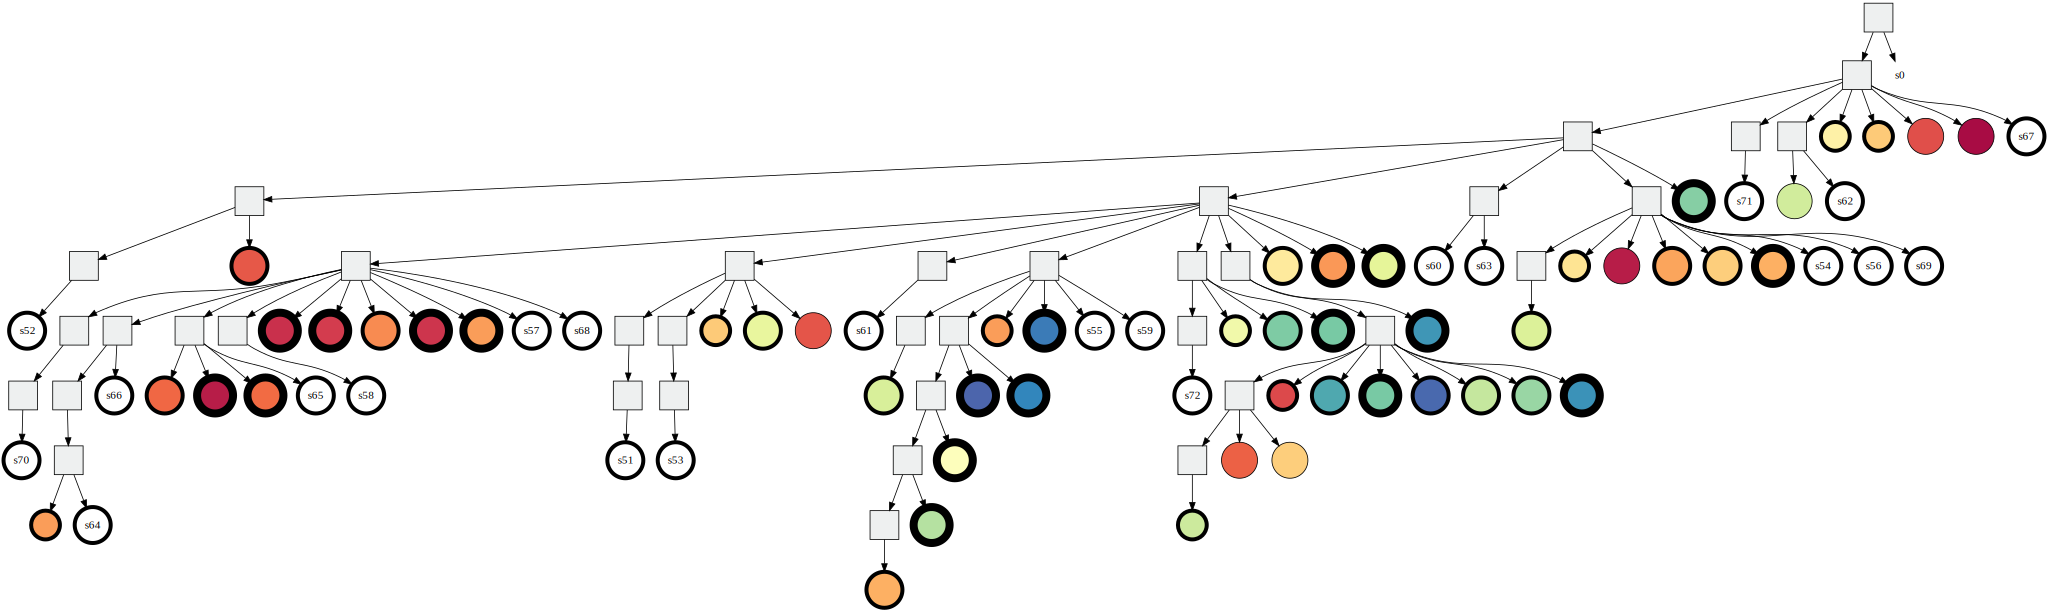

In [45]:
mem_time_style_tree(tree)
    
g = to_agraph(tree)
g.layout(prog='dot')
display(Source(g))

g.draw(f'../../data/YFV2001_figures/0.06_1_map0_mem_score_timepoint.svg')

#g.draw(f'../../data/YFV2001_figures/{error_rate}_map{tree_number}__mem_score_and_timepoint_full_tree.svg')

#g.draw(f'data/figs/mem_trees/YFV2001_sub1/YFV2001_sub1_{error_rate}_map{tree_number}_mem_scores_full_tree.pdf')


# Plotting individual clones

In [37]:
def extract_clone_tree(tree, target_clone):
    subtree = nx.DiGraph()
    subtree.graph = tree.graph
    
    source_node = get_root_node(tree)
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(tree, source_node):
        if post_node not in clones_purity:
            continue
        if edge_label == 'forward' and clones_purity.loc[target_clone, post_node] == 1.0:
            subtree.add_node(post_node)
            if clones_purity.loc[target_clone, pre_node] == 1.0:
                subtree.add_edge(pre_node, post_node)
        continue

        print(post_node)
        if pre_node not in clones_purity:
            print('missing', pre_node)
            continue
        if clones_purity[pre_node][target_clone] == 1.0 and edge_label == 'forward':
            print(pre_node, post_node, edge_label, clones_purity[pre_node][target_clone])
    return subtree

In [38]:
all_clones

['bulk', '107.0', '108.0', '118.0', '122.0', '143.0', '149.0']

In [39]:
# Print file

the_clone = ['143.0']

for c in the_clone:
    display(Markdown(f'# Clone {c}'))
    subtree = extract_clone_tree(tree, target_clone=c)
    mem_style_tree(subtree)
    
    g = to_agraph(subtree)
    g.layout(prog='dot')
    #g.draw(f'data/figs/mem_trees/YFV2001_sub1/mem_score/YFV2001_sub1_{error_rate}_map{tree_number}_clone_{c}.pdf')
    Source(g)

# Clone 143.0

# Clone bulk

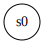

# Clone 107.0

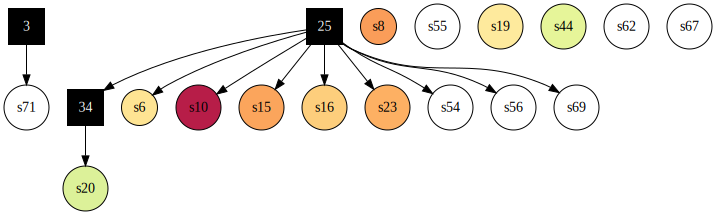

# Clone 108.0

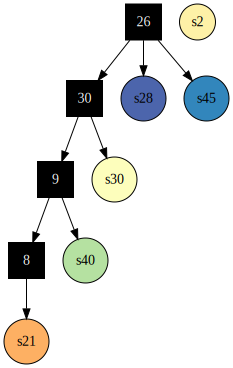

# Clone 118.0

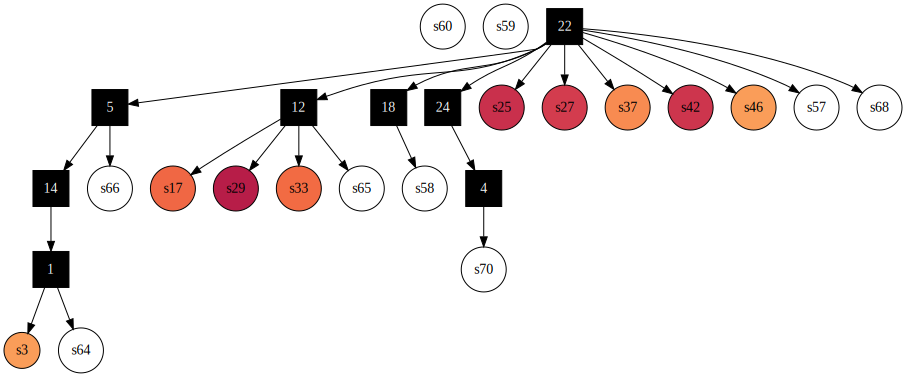

# Clone 122.0

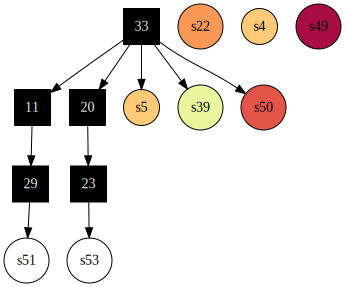

# Clone 143.0

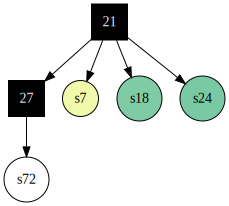

# Clone 149.0

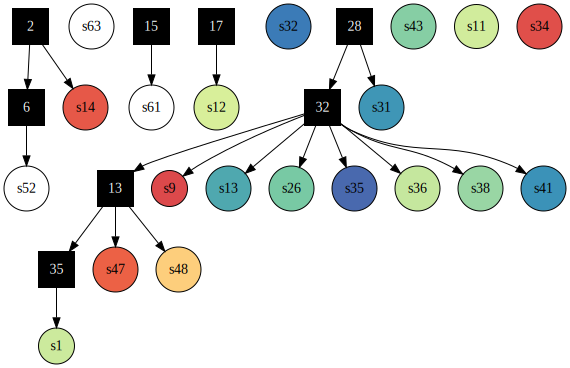

In [40]:
for c in all_clones:
    display(Markdown(f'# Clone {c}'))
    subtree = extract_clone_tree(tree, target_clone=c)
    mem_style_tree(subtree)
    
    g = to_agraph(subtree)
    g.layout(prog='circo')
    display(Source(g))

In [41]:
clones_data.timepoint.unique()

array([ nan,  15., 136., 593.])

In [42]:
time_to_width_map = {15.0: 1, 136.0: 5, 593.0: 10}

def mem_time_style_tree(tree):
    for n in tree.nodes:
        node_dict = tree.nodes[n]
        if n.startswith('s'):
            # This is the style for sample nodes
            node_dict['shape'] = 'circle'
            if n not in cell_id_to_mem_score:
                node_dict['fillcolor'] = 'white'
                node_dict['fontcolor'] = 'white'
            else:
                time = cell_id_to_time[n]
                score = cell_id_to_mem_score[n]
                node_dict['penwidth'] = time_to_width_map.get(time, 0)
                if np.isnan(score):
                    node_dict['fillcolor'] = 'white'
                    node_dict['color'] = 'black'
                else:
                    node_dict['fillcolor'] = rgb_to_hex(mem_score_colors[int(score*100)])
                    node_dict['fontcolor'] = rgb_to_hex(mem_score_colors[int(score*100)])
        else:
            if n in clones_purity:
                # This is the style for mutation nodes
                # Color is a mix of purities
                #node_dict['fillcolor'] = rgb_to_hex(mix_clones_colors(n, clones_purity))
                node_dict['fillcolor'] = '#EEF0F0'
                node_dict['fontcolor'] = '#EEF0F0'
            else:
                # Dangling mutation node
                node_dict['fillcolor'] = 'black'

    tree.graph['node']['shape'] = 'square'
    tree.graph['node']['fontcolor'] = 'black'
    tree.graph['node']['color'] = 'black'
    tree.graph['node']['style'] = 'filled,solid'
    tree.graph['edges'] = {'arrowsize': '4.0'}

In [43]:
all_clones

['bulk', '107.0', '108.0', '118.0', '122.0', '143.0', '149.0']

# Clone 149.0

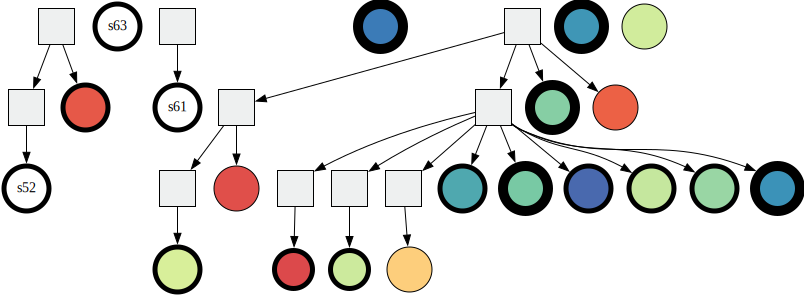

In [33]:
the_clone = ['149.0']

for c in the_clone:
    display(Markdown(f'# Clone {c}'))
    subtree = extract_clone_tree(tree, target_clone=c)
    mem_time_style_tree(subtree)
    
    g = to_agraph(subtree)
    g.layout(prog='dot')
    #g.draw(f'data/figs/mem_trees/YFV2001_sub1/mem_score_and_timepoint/YFV2001_sub1_{error_rate}_map{tree_number}_clone_{c}_memscore_and_timepoint.pdf')
    #g.draw(f'../../data/YFV2001_figures/{error_rate}_map{tree_number}_clone_{c}_mem_score_and_timepoint.svg')
    display(Source(g))

# Clone bulk

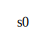

# Clone 107.0

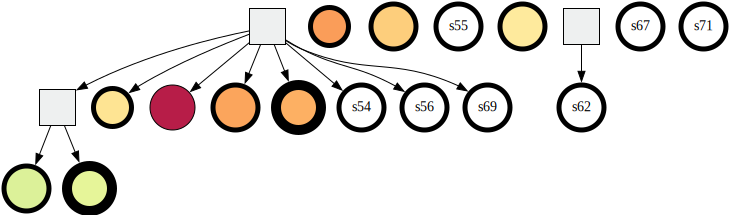

# Clone 108.0

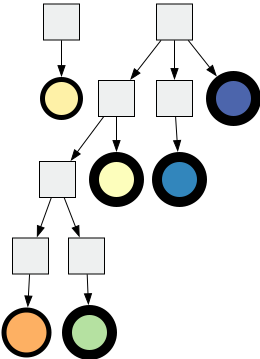

# Clone 118.0

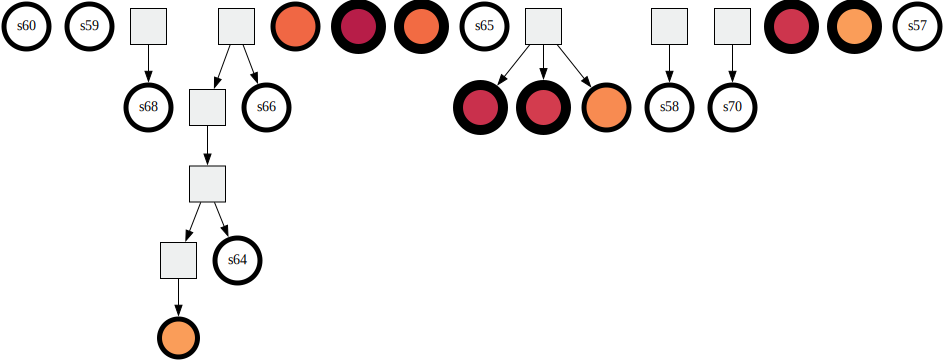

# Clone 122.0

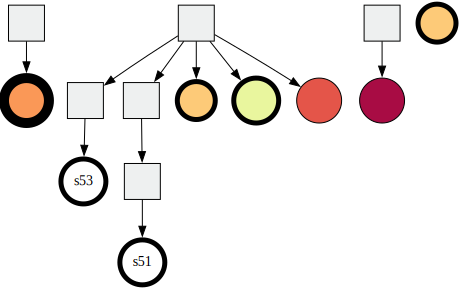

# Clone 143.0

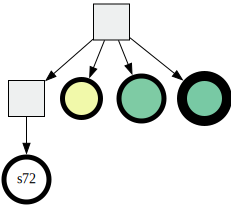

# Clone 149.0

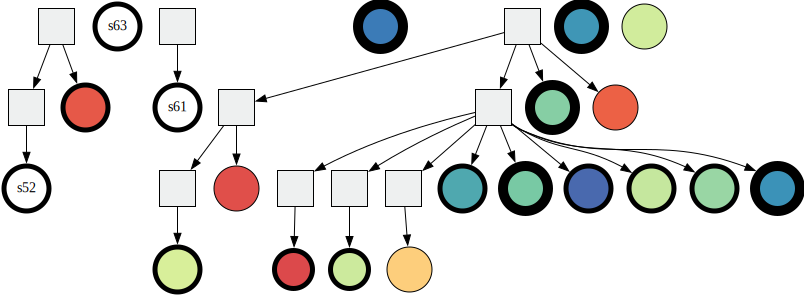

In [34]:
for c in all_clones:
    display(Markdown(f'# Clone {c}'))
    subtree = extract_clone_tree(tree, target_clone=c)
    mem_time_style_tree(subtree)
    
    g = to_agraph(subtree)
    g.layout(prog='dot')
    display(Source(g))